# Imports

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.patches as mpatches
import os
import evaluate
import numpy as np
import tqdm
from collections import defaultdict

/home/bdrad/miniconda3/envs/report_gen/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2025-09-24 22:56:29.730301: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-24 22:56:29.730342: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-24 22:56:29.730379: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-24 22:56:29.738576: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use 

# Automated Benchmark

In [2]:
def bootstrap_ci(scores, n_bootstrap=10000, confidence_level=95):
    n_samples = len(scores)
    bootstrap_means = []
    for _ in range(n_bootstrap):
        resampled_scores = np.random.choice(scores, size=n_samples, replace=True)
        bootstrap_means.append(np.mean(resampled_scores))
    bootstrap_means = np.array(bootstrap_means)
    mean_score = np.mean(bootstrap_means)
    std_score = np.std(bootstrap_means)    
    lower_percentile = (100 - confidence_level) / 2
    upper_percentile = 100 - lower_percentile
    ci_lower = np.percentile(bootstrap_means, lower_percentile)
    ci_upper = np.percentile(bootstrap_means, upper_percentile)
    return mean_score, std_score, ci_lower, ci_upper

## Figure 3

In [4]:
MODELS = [
  "mistral",
  "llama",
  "qwen",
  "deepseek_llama",
  "deepseek_qwen",
  "biomistral",
  "meditron",
  "gpt4o",
  "gpt4o_mini",
  "claude3_5",
  "o1",
  "o1_mini",
  "referring_physician"
]

DISPLAY_NAMES = [
    'Mistral\nv0.3', 
    'Llama 3.1', 
    "Qwen 2.5",
    'DeepSeek\nLlama',
    'DeepSeek\nQwen',
    'BioMistral', 
    'Meditron3', 
    'GPT-4o', 
    'GPT-4o\nmini',
    "Claude 3.5\nSonnet",
    "o1",
    "o1 mini",
    "Referring Clinician"
]

fig3_model_statistics = {}
for model in tqdm.tqdm(MODELS):
    model_scores = pd.read_csv(f"../analysis/llm_evaluation_scores/{model}.csv")
    summary_statistics = {}
    statistics = ["rouge", "medcon", "radgraph", "bertscore"]
    for statistic in statistics:
        summary_statistics[f'{statistic}_mean'],\
        summary_statistics[f'{statistic}_std'],\
        summary_statistics[f'{statistic}_ci_lower'],\
        summary_statistics[f'{statistic}_ci_upper'] = bootstrap_ci(
            np.array(model_scores[statistic].tolist()), 
            n_bootstrap=10000
        )
    fig3_model_statistics[model] = summary_statistics

100%|████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.22it/s]


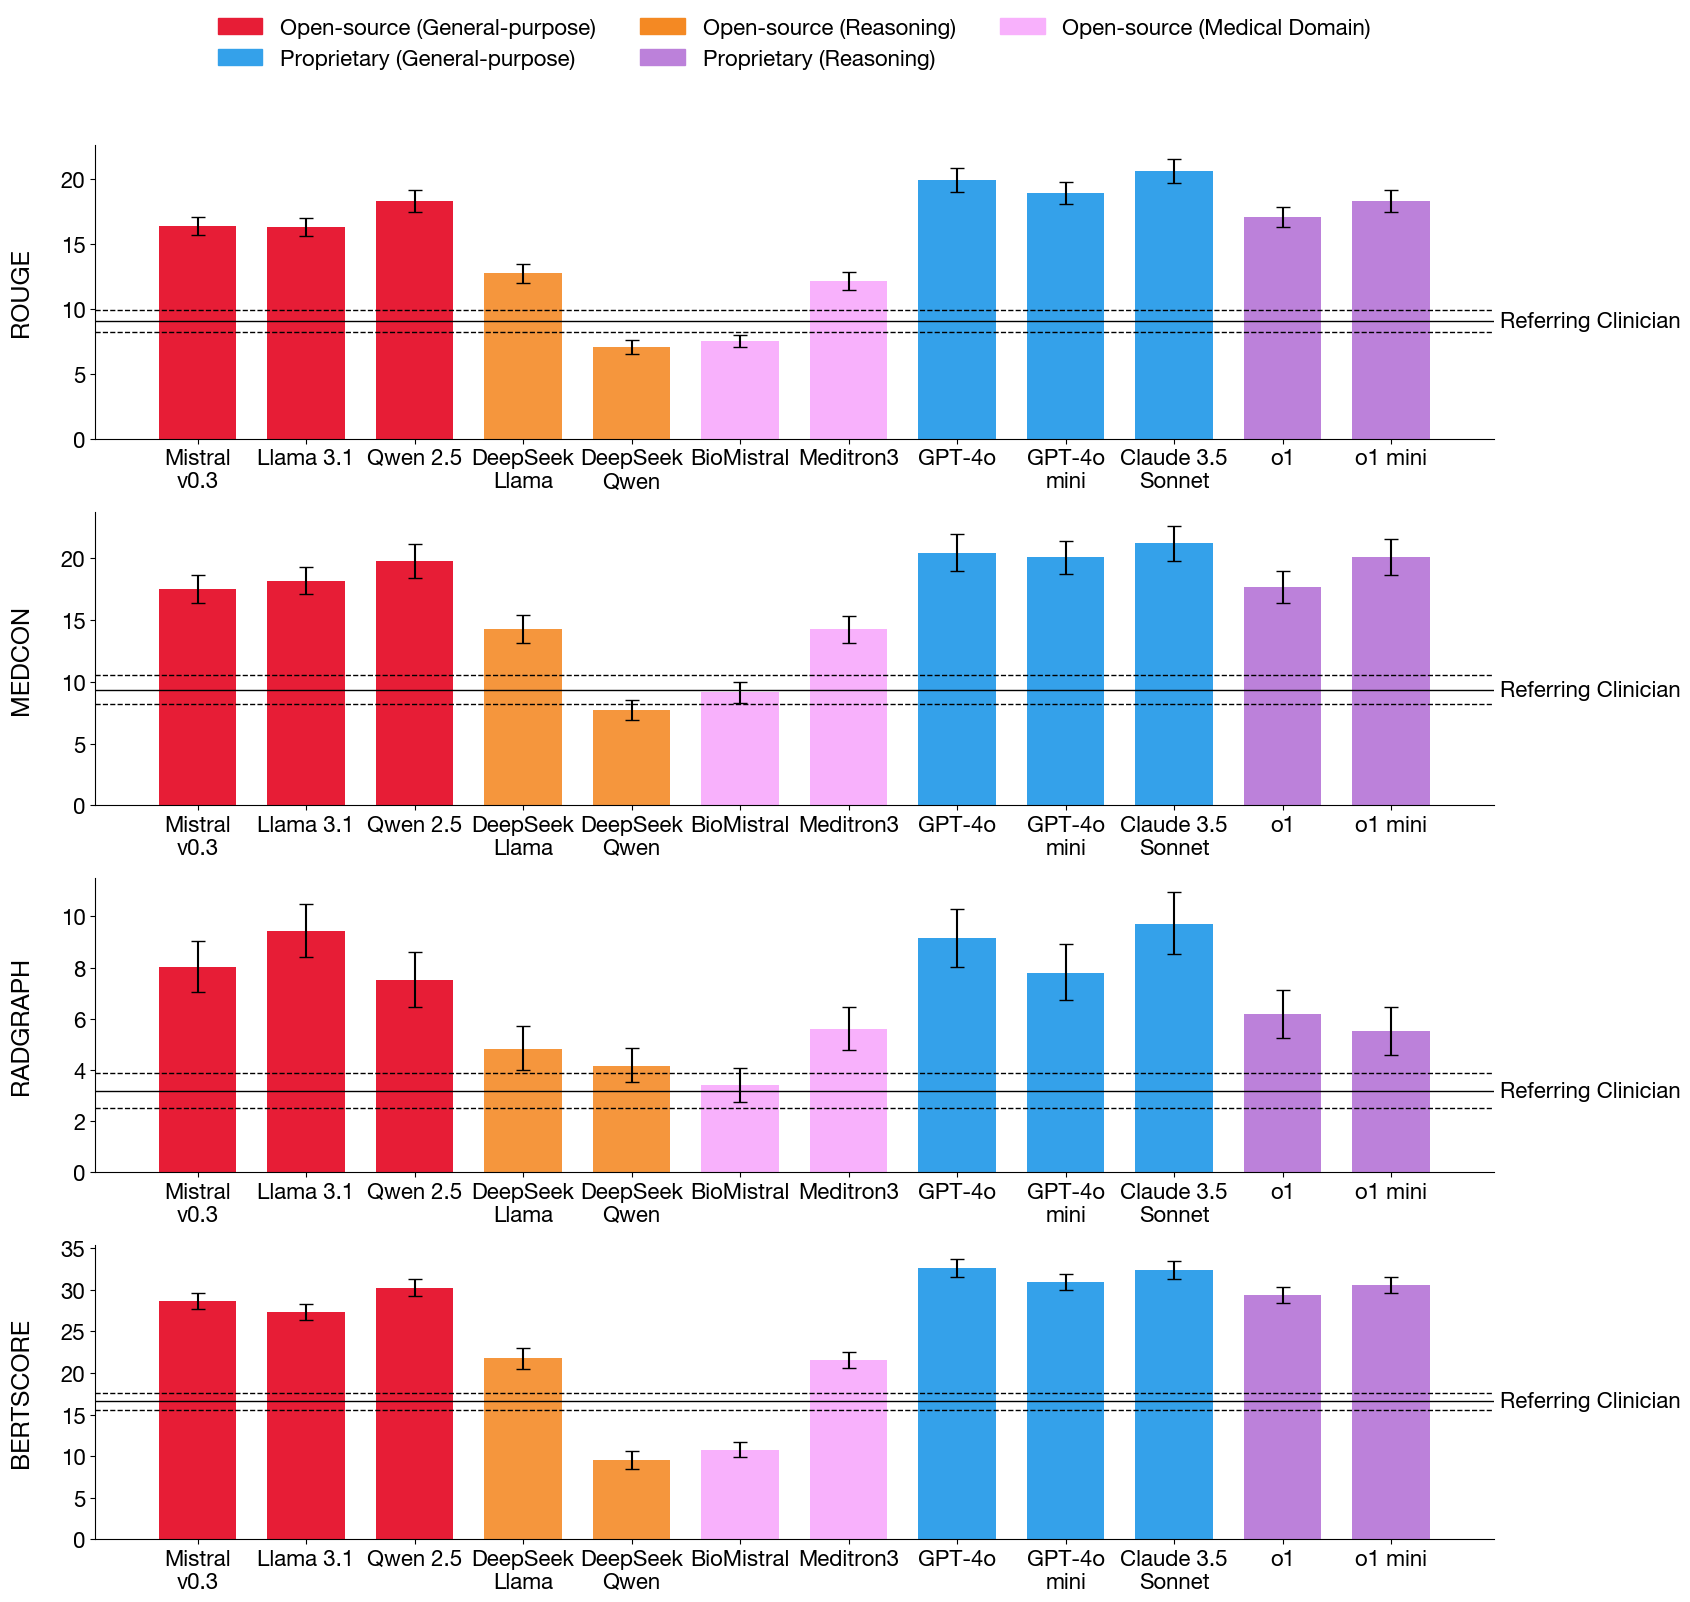

In [8]:
def fig3_plot_data(ax, metric, model_statistics, models, display_names, legend=False):
    score_means = []
    score_lower_errors = []
    score_upper_errors = []
    for model in models:
        if model != "referring_physician":
            stats = model_statistics[model]
            mean = stats[f'{metric}_mean']
            score_means.append(mean * 100) 
            lower_error = (mean - stats[f'{metric}_ci_lower']) * 100
            upper_error = (stats[f'{metric}_ci_upper'] - mean) * 100
            score_lower_errors.append(lower_error)
            score_upper_errors.append(upper_error)
    colors = [
        '#E71D36', 
        '#E71D36', 
        '#E71D36', 
        '#F5963D', 
        '#F5963D', 
        '#F8B1FC', 
        '#F8B1FC',
        "#34A1EA",
        '#34A1EA',
        '#34A1EA',
        '#BC81DA',
        '#BC81DA'
    ]

    x_positions = np.arange(len(display_names[:-1])) * 0.7  # Adjust the multiplier to control spacing

    bars = ax.bar(
        x_positions, 
        score_means, 
        yerr=[score_lower_errors, score_upper_errors], 
        capsize=5, 
        color=colors,
        width=0.5
    )

    ax.set_xticks(x_positions)
    ax.set_xticklabels(display_names[:-1])

    path = 'fonts/HelveticaNeue.ttf'
    fontprop = fm.FontProperties(fname=path, size=18) 
    
    ax.set_ylabel(metric.upper(), labelpad=20, fontproperties=fontprop)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    referring_stats = fig3_model_statistics['referring_physician']
    ref_mean = referring_stats[f'{metric}_mean'] * 100
    ref_ci_lower = referring_stats[f'{metric}_ci_lower'] * 100
    ref_ci_upper = referring_stats[f'{metric}_ci_upper'] * 100

    path = 'fonts/HelveticaNeue.ttf'
    fontprop = fm.FontProperties(fname=path, size=16) 
    
    # Define x as an array
    xmin, xmax = -0.5, len(display_names) - 0.5
    x = np.linspace(xmin, xmax, 100)
    ax.axhline(y=ref_ci_lower, color='black', linestyle='--', linewidth=1)
    ax.axhline(y=ref_mean, color='black', linestyle='-', linewidth=1, label='Referring Clinician')
    ax.axhline(y=ref_ci_upper, color='black', linestyle='--', linewidth=1)
    ax.text((len(display_names) - 1)*0.7, ref_mean, 'Referring Clinician', 
    color='black', va='center', ha='left', fontsize=16, fontproperties=fontprop)

    for label in ax.get_yticklabels():
        label.set_fontproperties(fontprop)
    for label in ax.get_xticklabels():
        label.set_fontproperties(fontprop)
    
    general_legend = mpatches.Patch(color='#E71D36', label='Open-source (General-purpose)')
    reasoning_legend = mpatches.Patch(color='#F48923', label='Open-source (Reasoning)')
    medical_legend = mpatches.Patch(color='#F8B1FC', label='Open-source (Medical Domain)')
    proprietary_legend = mpatches.Patch(color='#34A1EA', label='Proprietary (General-purpose)')
    proprietary_reasoning_legend = mpatches.Patch(color='#BC81DA', label='Proprietary (Reasoning)')

    if legend:
        ax.legend(
            handles=[general_legend, proprietary_legend, reasoning_legend, proprietary_reasoning_legend, medical_legend], 
            prop=fontprop,
            loc='upper center', 
            ncols=3, 
            frameon=False, 
            bbox_to_anchor=(0.5, 1.5)
        )

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(17, 16))
fig3_plot_data(ax[0], "rouge", fig3_model_statistics, MODELS, DISPLAY_NAMES, legend=True)
fig3_plot_data(ax[1], "medcon", fig3_model_statistics, MODELS, DISPLAY_NAMES)
fig3_plot_data(ax[2], "radgraph", fig3_model_statistics, MODELS, DISPLAY_NAMES)
fig3_plot_data(ax[3], "bertscore", fig3_model_statistics, MODELS, DISPLAY_NAMES)

# fig.subplots_adjust(wspace=0.4, hspace=0.85, left=0.1, right=0.9, top=0.9, bottom=0.1)

plt.tight_layout()
plt.savefig("figures/fig3_automated_llm_evaluation_dataset.png", dpi=300)

## Figure 4

In [10]:
BEST_OPEN_SOURCE = "qwen"
BEST_PROPRIETARY = "claude3_5"
REFERRING_PHYSICIAN = "referring_physician"
BODY_SYSTEMS = ["Head", "Neck", "Chest", "Abdomen/Pelvis", "MSK"]
PATHOPHYSIOLOGICAL_CATEGORIES = ["Cancer/Mass", "Symptom-based", "Surgical", "Infection/Inflammatory", "Structural"]
DISPLAY_NAMES = {
    BEST_OPEN_SOURCE: 'Best open-source LLM (Qwen 2.5-7B Instruct)',
    BEST_PROPRIETARY: 'Best proprietary LLM (Claude 3.5 Sonnet)',
    REFERRING_PHYSICIAN: 'Referring Clinician'
}
DISPLAY_LABELS = {
    "body_system": ["Brain", "Head/Neck", "Chest", "Abdomen/\nPelvis", "MSK"],
    "pathophysiological_category": ["Cancer/\nMass", "Symptom-based", "Surgical", "Infection/\nInflammatory", "Structural"]
}
groupings = {
    "body_system": BODY_SYSTEMS,
    "pathophysiological_category": PATHOPHYSIOLOGICAL_CATEGORIES
}
fig4_model_statistics = defaultdict(dict)
models = [BEST_OPEN_SOURCE, BEST_PROPRIETARY, REFERRING_PHYSICIAN]

for model in models:
    print("Model:", model)
    df = pd.read_csv(f"../analysis/llm_evaluation_scores/{model}.csv")
    
    for grouping, labels in groupings.items():
        # Initialize dictionary to hold metrics for this grouping.
        metrics_data = {metric: {"scores": [], "ci_lower": [], "ci_upper": []} 
                        for metric in ["rouge", "medcon", "radgraph", "bertscore"]}
        
        for label in labels:
            group_df = df[df[grouping] == label]
            
            for metric in metrics_data.keys():
                # Compute the mean and confidence intervals.
                mean, _, ci_lower, ci_upper = bootstrap_ci(group_df[metric].to_numpy(), n_bootstrap=10000)
                metrics_data[metric]["scores"].append(mean * 100)
                metrics_data[metric]["ci_lower"].append((mean - ci_lower) * 100)
                metrics_data[metric]["ci_upper"].append((ci_upper - mean) * 100)
        
        fig4_model_statistics[model][grouping] = metrics_data

Model: qwen
Model: claude3_5
Model: referring_physician


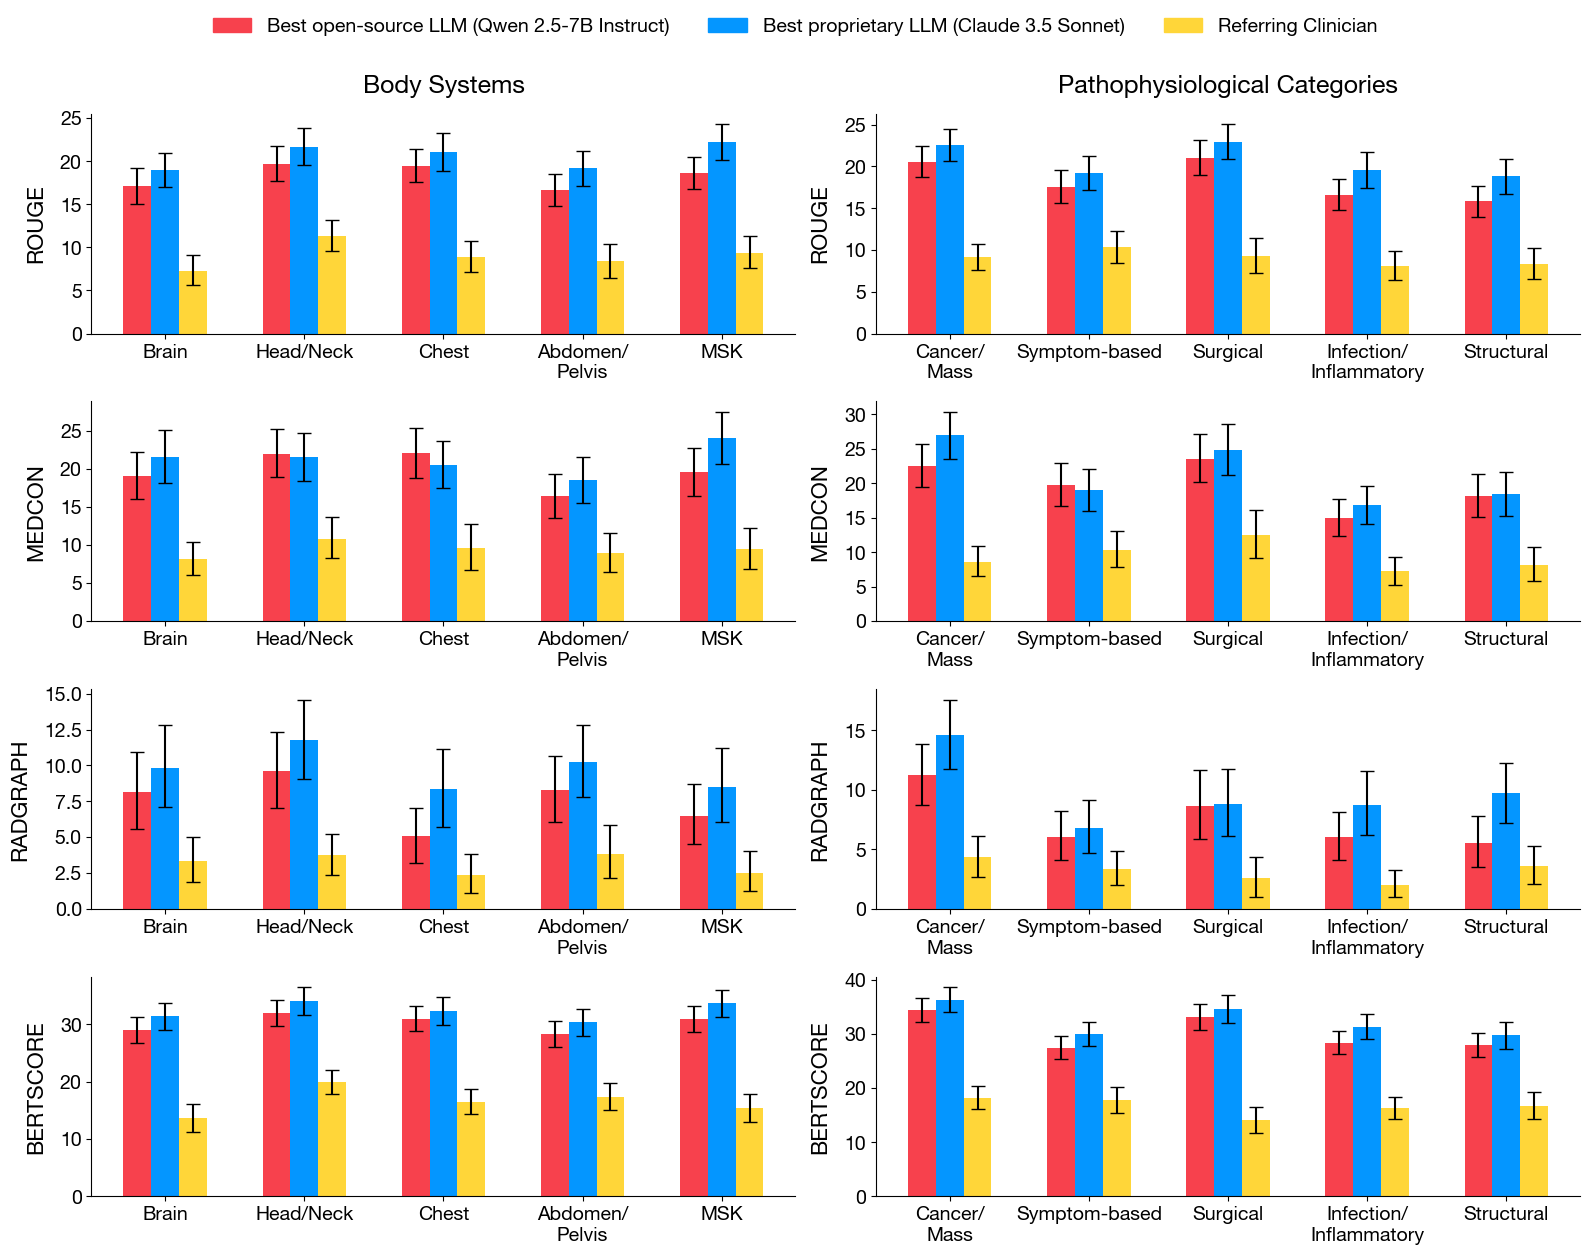

In [11]:
metrics = ["ROUGE", "MEDCON", "RADGRAPH", "BERTSCORE"]
bar_width = 0.2
colors = ['#F7414D', '#0496FF', '#FFD639']

fig, axes = plt.subplots(4, 2, figsize=(16, 12))
grouping_titles = ["Body Systems", "Pathophysiological Categories"]

path = 'fonts/HelveticaNeue.ttf'

for row, metric in enumerate(metrics):
    for col, (grouping, labels) in enumerate(DISPLAY_LABELS.items()):
        ax = axes[row, col]
        x = np.arange(len(labels))
        
        # For each model, plot its values with error bars.
        for idx, model in enumerate(models):
            key = metric.lower()  # e.g., "rouge"
            values = fig4_model_statistics[model][grouping][key][f"scores"]
            ci_lower = fig4_model_statistics[model][grouping][key][f"ci_lower"]
            ci_upper = fig4_model_statistics[model][grouping][key][f"ci_upper"]
            
            # Position bars: subtract bar_width for the first model, no shift for second, add for third.
            ax.bar(x + (idx - 1) * bar_width, values, bar_width,
                   yerr=[ci_lower, ci_upper], capsize=5,
                   label=DISPLAY_NAMES[model], color=colors[idx])

        fontprop = fm.FontProperties(fname=path, size=16) 
        
        ax.set_ylabel(metric, fontproperties=fontprop, labelpad=10)
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        fontprop = fm.FontProperties(fname=path, size=14) 

        for label in ax.get_xticklabels():
            label.set_fontproperties(fontprop) 
        for label in ax.get_yticklabels():
            label.set_fontproperties(fontprop) 
        
        if row == 0:
            fontprop = fm.FontProperties(fname=path, size=18) 
            ax.set_title(grouping_titles[col], fontproperties=fontprop, pad=15)

legend_handles = [mpatches.Patch(color=colors[i], label=DISPLAY_NAMES[model]) 
                  for i, model in enumerate(models)]

fontprop = fm.FontProperties(fname=path, size=14) 
fig.legend(handles=legend_handles, loc='upper center', ncol=3, frameon=False, prop=fontprop, bbox_to_anchor=(0.5, 1.05))
fig.tight_layout()
fig.savefig("figures/fig4_best_automated_llm_evaluation_dataset.png", dpi=300, bbox_inches="tight")

## Table 2

In [ ]:
BASEPATH = "/mnt/sohn2022/Adrian/rad-llm-pmhx/inference/results/llm_automated_evaluation_dataset"
MODEL_DICT = {
    "mistral": "mistralai_Mistral-7B-Instruct-v0.3",
    "llama": "meta-llama_Meta-Llama-3.1-8B-Instruct",
    "qwen": "Qwen_Qwen2.5-7B-Instruct",
    "deepseek_llama": "deepseek-ai_DeepSeek-R1-Distill-Llama-8B",
    "deepseek_qwen": "deepseek-ai_DeepSeek-R1-Distill-Qwen-7B",
    "biomistral": "BioMistral_BioMistral-7B",
    "meditron": "OpenMeditron_Meditron3-8B",
    "o1": "o1",
    "o1_mini": "o1_mini",
    "gpt4o": "gpt4o",
    "gpt4o_mini": "gpt4o_mini",
    "claude3_5": "claude3_5",
}

automated_llm_evaluation_dataset = pd.read_parquet("../dataset/llm_automated_evaluation_dataset.parquet")
llm_data = [automated_llm_evaluation_dataset]
for MODEL in MODEL_DICT:
    MODEL_NAME = MODEL_DICT[MODEL]
    df = pd.read_csv(f"{BASEPATH}/{MODEL_NAME}_0_1000.csv").fillna("")
    df = df.rename(columns={"llm_indication": f"llm_indication_{MODEL}"})[[f"llm_indication_{MODEL}"]]
    llm_data.append(df)
    
llm_indication_results = pd.concat(llm_data, axis=1)

In [ ]:
subset = llm_indication_results.copy()
# Head, MSK, Abdomen/Pelvis, Neck, Chest
# subset = subset[subset["body_system"] == "Chest"]
# Cancer/Mass, Symptom-based, Surgical, Infection/Inflammatory, Structural
subset = subset[subset["pathophysiological_category"] == "Structural"]

i = 5
row = subset.iloc[i]

print("Referring Physician")
print("="*20)
print(row["original_history"])

print("Radiologist")
print("="*20)
print(row["additional_history"])

print("Qwen")
print("="*20)
print(row["llm_indication_qwen"])

print("Claude 3.5-Sonnet")
print("="*20)
print(row["llm_indication_claude3_5"])

# Clinical Reader Study

In [3]:
reader_study_results = pd.read_csv("final_llm_reader_study_results.csv")
reader_study_evaluation_dataset = pd.read_parquet("../dataset/randomized_reader_study_evaluation.parquet")

## Case Assignments 

In [4]:
#create small groupings, this is necessary for uniform distribution to ensure equal group sizing (in setting of a rectangular matrix...)
# we want 25 cases per person for 20 people  , 2 repeats of each case , so we want a dimension 10 matrix , 5 groupings of 3 and 5 groupings of 2
X = list()
for i in range(10):
    row = list()
    for j in range(10):
        if (j - i) % 10 in [0, 1, 2, 3, 4]:
            row.append(3)
        else:
            row.append(2)
    X.append(row)

# use X and our index array to create a matrix of the actual cases, grouped according to small groups defined in X - call this matrix Y.
# essentially we are sampling from the case index (labeled index) and drawing # of cases according to matrix X
# well its a "matrix" but really the structure is a list of lists. the first index will refer to the "row" and the second index will be the "column"
# Y will be a square matrix by construction

index = list(range(250))
Y = list()
start_index=0

for i in range(10):
    row = list()
    for j in range(10):
        row.append(index[start_index:start_index+X[i][j]])
        #update start_index
        start_index=start_index+X[i][j]
    Y.append(row)

# use matrix Y to create the final assignments by taking the union across each row to create the first set of 10 cases and then do the same by column for the second set of 10 cases store these as arrays
case_assignments=list()

#first assignment for first 10 raters, read along rows of Y
for i in range(10):
    case_assignments.append([element for row in Y[i] for element in row])

#second assignment for raters 11-20, read along columns of Y, create array of arrays to store reworked values. unfortunately list of lists makes this hard so create a temporary matrix Y2 first which is a transpose of Y
Y2= [Y[j][i] for i in range(10) for j in range(10)]

for i in range(10):
    case_assignments.append(([element for row in Y2[10*i:10*i+10] for element in row]))

## Collating Study Reader Results

In [5]:
import pandas as pd
import numpy as np
from collections import defaultdict

all_rows = []

NUM_USERS = 20
for user_id in range(1, NUM_USERS + 1):
    eval_subset = reader_study_evaluation_dataset.iloc[case_assignments[user_id - 1]].reset_index(drop=True)
    results_subset = reader_study_results[reader_study_results["user_id"] == user_id].sort_values(by="set_id").reset_index(drop=True)

    for i in range(len(results_subset)):
        eval_row = eval_subset.iloc[i]
        result_row = results_subset.iloc[i]


        global_set_id = case_assignments[user_id - 1][i]
        category = eval_row.get("pathophysiological_category", np.nan)
        body_system = eval_row.get("body_system", np.nan)

        protocol_ranks = json.loads(result_row.get("protocol_usefulness_ranking", "{}"))
        interpretation_ranks = json.loads(result_row.get("interpretation_usefulness_ranking", "{}"))
        overall_ranks = json.loads(result_row.get("overall_ranking", "{}"))

        for n in range(1, 5):
            source = eval_row.get(f"indication{n}_choice", None)
            comp = result_row.get(f"indication_{n}_comprehensiveness", None)
            fact = result_row.get(f"indication_{n}_factuality", None)
            conc = result_row.get(f"indication_{n}_conciseness", None)
            indication_comment = result_row.get(f"indication_{n}_comment", None)

            note_texts = eval_row.get("note_texts", None)
            note_titles = eval_row.get("note_titles", None)
            indication_text = eval_row.get(source, None)
            general_comment = result_row.get("general_comment", None)
            
            indication_key = f"Indication {n}"
            protocol_rank = protocol_ranks.get(indication_key, None)
            interpretation_rank = interpretation_ranks.get(indication_key, None)
            overall_rank = overall_ranks.get(indication_key, None)

            factor_ranking_str = result_row.get("factor_ranking", None)
            try:
                factor_ranking_dict = json.loads(factor_ranking_str) if factor_ranking_str else {}
                sorted_factors = sorted(factor_ranking_dict, key=factor_ranking_dict.get)
                factor_ranking_1 = sorted_factors[0] if len(sorted_factors) > 0 else None
                factor_ranking_2 = sorted_factors[1] if len(sorted_factors) > 1 else None
                factor_ranking_3 = sorted_factors[2] if len(sorted_factors) > 2 else None
            except:
                factor_ranking_1 = factor_ranking_2 = factor_ranking_3 = None

            if source is not None:
                all_rows.append({
                    "user_id": user_id,
                    "global_set_id": global_set_id,
                    # "note_texts": note_texts,
                    # "note_titles": note_titles,
                    "indication_comment": indication_comment,
                    "general_comment": general_comment,
                    "pathophysiological_category": category,
                    "body_system": body_system,
                    "source": source,
                    "indication_text": indication_text,
                    "comprehensiveness": comp,
                    "factuality": fact,
                    "conciseness": conc,
                    "protocol_usefulness_rank": protocol_rank,
                    "interpretation_usefulness_rank": interpretation_rank,
                    "overall_rank": overall_rank,
                    "factor_ranking_1": factor_ranking_1,
                    "factor_ranking_2": factor_ranking_2,
                    "factor_ranking_3": factor_ranking_3,
                })

collated_reader_study_results = pd.DataFrame(all_rows)

## Exclusion

In [6]:
excluded_set_ids = [29,73,105,122,141,143,152,166,184]
collated_reader_study_results = collated_reader_study_results[
    ~collated_reader_study_results["global_set_id"].isin(excluded_set_ids)
]

## Figure 5

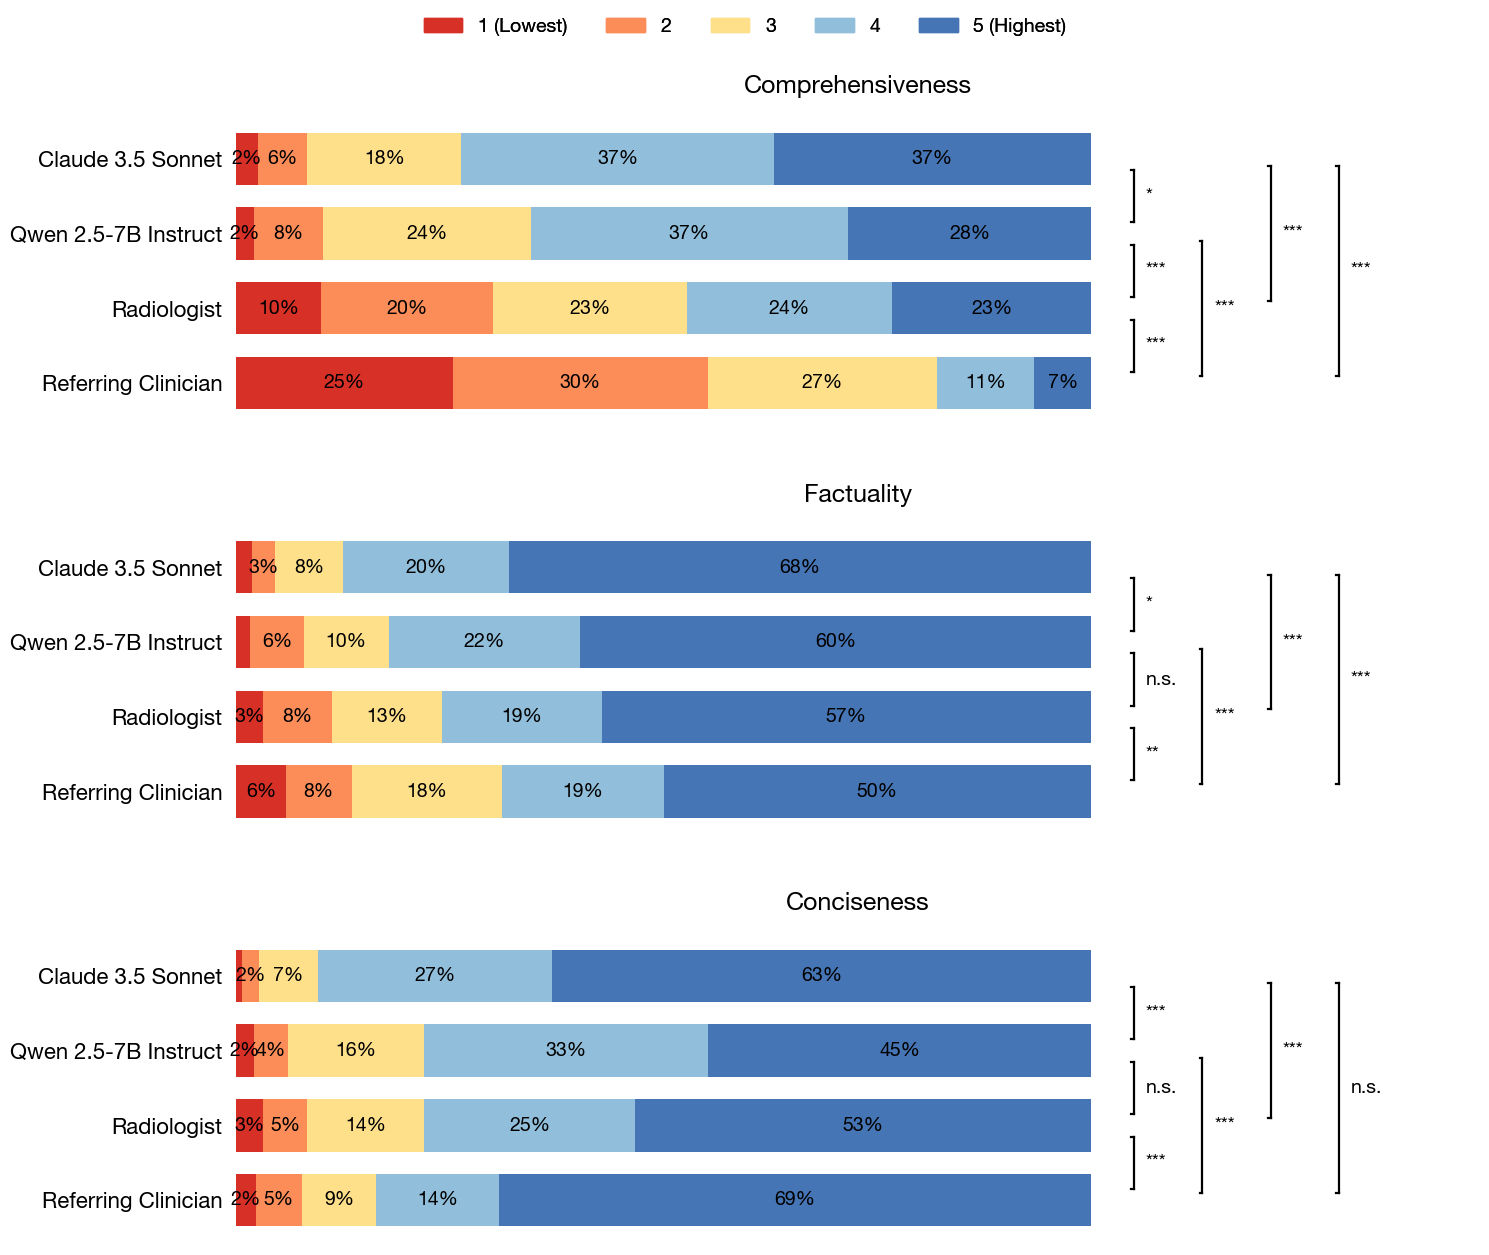

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.font_manager as fm

# =========================
# Config
# =========================
BEST_OPEN_SOURCE     = "llm_indication_qwen"
BEST_PROPRIETARY     = "llm_indication_claude"
REFERRING_PHYSICIAN  = "original_history"
RADIOLOGIST          = "additional_history"

DISPLAY_NAMES = {
    BEST_OPEN_SOURCE: 'Qwen 2.5-7B Instruct',
    BEST_PROPRIETARY: 'Claude 3.5 Sonnet',
    REFERRING_PHYSICIAN: 'Referring Clinician',
    RADIOLOGIST: "Radiologist"
}

model_order    = [REFERRING_PHYSICIAN, RADIOLOGIST, BEST_OPEN_SOURCE, BEST_PROPRIETARY]
likert_fields  = ["comprehensiveness", "factuality", "conciseness"]
subplot_titles = ["Comprehensiveness", "Factuality", "Conciseness"]
likert_levels  = [1, 2, 3, 4, 5]
colors_likert  = ['#d73027', '#fc8d59', '#fee08b', '#91bfdb', '#4575b4']
font_path      = "fonts/HelveticaNeue.ttf"

F_TITLE = fm.FontProperties(fname=font_path, size=18)
F_AXIS  = fm.FontProperties(fname=font_path, size=16)
F_LABEL = fm.FontProperties(fname=font_path, size=14)

VALUE_LABEL_THRESHOLD = 2.0  # print inside bar only if segment >= 2%

# Pairwise significance (supply your p-values)
sig_by_field = {
    "comprehensiveness": [
        (REFERRING_PHYSICIAN, RADIOLOGIST,        1e-3),
        (REFERRING_PHYSICIAN, BEST_PROPRIETARY,   1e-3),
        (REFERRING_PHYSICIAN, BEST_OPEN_SOURCE,   1e-3),
        (RADIOLOGIST,         BEST_PROPRIETARY,   1e-3),
        (RADIOLOGIST,         BEST_OPEN_SOURCE,   1e-3),
        (BEST_PROPRIETARY,    BEST_OPEN_SOURCE,   0.039),
    ],
    "factuality": [
        (REFERRING_PHYSICIAN, RADIOLOGIST,        0.009),
        (REFERRING_PHYSICIAN, BEST_PROPRIETARY,   1e-3),
        (REFERRING_PHYSICIAN, BEST_OPEN_SOURCE,   1e-3),
        (RADIOLOGIST,         BEST_PROPRIETARY,   1e-3),
        (RADIOLOGIST,         BEST_OPEN_SOURCE,   0.12),
        (BEST_PROPRIETARY,    BEST_OPEN_SOURCE,   0.031),
    ],
    "conciseness": [
        (REFERRING_PHYSICIAN, RADIOLOGIST,        1e-3),
        (REFERRING_PHYSICIAN, BEST_PROPRIETARY,   0.56),
        (REFERRING_PHYSICIAN, BEST_OPEN_SOURCE,   1e-3),
        (RADIOLOGIST,         BEST_PROPRIETARY,   1e-3),
        (RADIOLOGIST,         BEST_OPEN_SOURCE,   0.79),
        (BEST_PROPRIETARY,    BEST_OPEN_SOURCE,   1e-3),
    ],
}

# =========================
# Hard-coded tiering (row indices)
# =========================
TIER_MAP = {
    (0, 1): 0, (1, 2): 0, (2, 3): 0,  # same column/level
    (0, 2): 1,                        # next level out
    (1, 3): 2,                        # next level out
    (0, 3): 3,                        # outermost
}

def p_to_label(p):
    return "***" if p <= 1e-3 else ("**" if p <= 1e-2 else ("*" if p <= 5e-2 else "n.s."))

# Base inset from row edges; larger for tier 0 chain, smaller for outer tiers
BASE_INSET_BY_TIER = {0: 0.0, 1: 0.10, 2: 0.10, 3: 0.10}
# Extra separation inserted at the shared boundary for ADJACENT pairs (y2 == y1 + 1)
ADJACENT_GAP = 0.3   # increase if you want more distance between (0,1) and (1,2), etc.

def add_sig_bracket(ax, y1, y2, text, tier,
                    x_base, tier_step=3.8, tick=0.30, lw=1.6, text_pad=1.1):
    """
    Draw vertical bracket to the RIGHT of bars at a fixed column for the given tier.
    Ensures extra vertical separation between ADJACENT pairs sharing a boundary
    (e.g., (0,1) vs (1,2)) by pulling them away from the boundary.
    """
    x0 = x_base + tier * tier_step
    a, b = sorted((y1, y2))
    inset = BASE_INSET_BY_TIER.get(tier, 0.10)

    # Start with symmetric inset away from the row edges
    ylow  = a + inset
    yhigh = b - inset

    # If this bracket is adjacent (b == a+1), we nudge it away from the shared boundary:
    #   - if this bracket is the LOWER neighbor (top ends at boundary), pull its top DOWN
    #   - if this bracket is the UPPER neighbor (bottom starts at boundary), push its bottom UP
    if b == a + 1:
        # Determine which side is near the boundary and adjust:
        # For (a, a+1): boundary is at y=a+1
        # If this bracket is the lower one (ends at boundary), reduce yhigh
        # If the upper one (starts at boundary), increase ylow
        # We don't know its neighbor here, so apply HALF the gap to BOTH sides:
        yhigh -= ADJACENT_GAP / 2.0
        ylow  += ADJACENT_GAP / 2.0

    # vertical
    ax.plot([x0, x0], [ylow, yhigh], color="black", linewidth=lw, zorder=5, clip_on=False)
    # ticks
    ax.plot([x0 - tick, x0], [ylow,  ylow],  color="black", linewidth=lw, zorder=5, clip_on=False)
    ax.plot([x0 - tick, x0], [yhigh, yhigh], color="black", linewidth=lw, zorder=5, clip_on=False)
    # text
    ax.text(x0 + tick + text_pad, (ylow + yhigh)/2, text,
            va="center", ha="left", fontproperties=F_LABEL, zorder=5, clip_on=False)

# =========================
# Precompute bracket tiers per field and global max tier
# =========================
idx_of = {src: j for j, src in enumerate(model_order)}
field_pairs = {}      # field -> list of (y1, y2, label, tier)
global_max_tier = -1

for field, rows in sig_by_field.items():
    entries = []
    for a, b, p in rows:
        y1, y2 = idx_of[a], idx_of[b]
        if y1 > y2: y1, y2 = y2, y1
        key = (y1, y2)
        if key in TIER_MAP:
            tier = TIER_MAP[key]
            entries.append((y1, y2, p_to_label(p), tier))
            global_max_tier = max(global_max_tier, tier)
    field_pairs[field] = entries

# =========================
# Figure
# =========================
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 12), sharex=False)
ytick_labels = [DISPLAY_NAMES.get(src, src) for src in model_order]

# Horizontal spacing for the bracket columns (+ consistent margins)
gap = 0        # space from end of bars to first bracket column
tier_step = 8    # column separation
label_buffer = 8.5 # room for "***" after outer column

for i, field in enumerate(likert_fields):
    ax = axes[i]

    # 1) Aggregate Likert distributions
    df = (
        collated_reader_study_results
        .groupby(["source", field])
        .size()
        .unstack(fill_value=0)
    )
    df = df.reindex(columns=likert_levels, fill_value=0)
    df = df.reindex(index=model_order, fill_value=0)

    score_percents = df.div(df.sum(axis=1).replace(0, np.nan), axis=0).fillna(0) * 100

    # 2) Plot stacked bars
    score_percents.plot(
        kind="barh", stacked=True, ax=ax,
        color=colors_likert, width=0.7, legend=False
    )

    # 3) Axes & style
    ax.set_title(subplot_titles[i], fontproperties=F_TITLE, pad=15)
    ax.set_ylabel("")
    ax.set_yticks(range(len(model_order)))
    ax.set_yticklabels(ytick_labels, fontproperties=F_AXIS)
    ax.get_xaxis().set_visible(False)
    ax.tick_params(axis='y', labelrotation=0, length=0, pad=10)
    for s in ax.spines.values():
        s.set_visible(False)

    # 4) Segment % labels
    for y_idx, row in enumerate(score_percents.values):
        x = 0.0
        for pct in row:
            if pct >= VALUE_LABEL_THRESHOLD:
                ax.text(x + pct/2.0, y_idx, f"{pct:.0f}%",
                        va="center", ha="center", fontproperties=F_LABEL)
            x += pct

    # 5) Brackets with adjacent-pair separation
    entries = field_pairs.get(field, [])
    if entries:
        data_right = ax.get_xlim()[1]
        extra = gap + (global_max_tier + 1) * tier_step + label_buffer
        ax.set_xlim(0, data_right + extra)
        x_base = data_right + gap

        for y1, y2, lab, tier in entries:
            add_sig_bracket(ax, y1, y2, lab, tier,
                            x_base=x_base, tier_step=tier_step,
                            tick=0.30, lw=1.6, text_pad=1.1)

# 6) Legend with annotations
likert_patches = []
for c, lv in zip(colors_likert, likert_levels):
    if lv == 1:
        label = "1 (Lowest)"
    elif lv == 5:
        label = "5 (Highest)"
    else:
        label = str(lv)
    likert_patches.append(mpatches.Patch(color=c, label=label))

fig.legend(handles=likert_patches,
           loc='upper center',
           ncol=5,
           frameon=False,
           prop=F_LABEL,
           bbox_to_anchor=(0.5, 1.05))
fig.legend(handles=likert_patches, loc='upper center', ncol=5, frameon=False,
           prop=F_LABEL, bbox_to_anchor=(0.5, 1.05))

fig.tight_layout(h_pad=4.0)
fig.savefig("figures/fig5_reader_study_likert_scores.png", dpi=300, bbox_inches="tight")

## Figure 6

/tmp/ipykernel_208205/2115919388.py:216: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0.03, 0, 1, 0.97])  # leave space at left for A/B


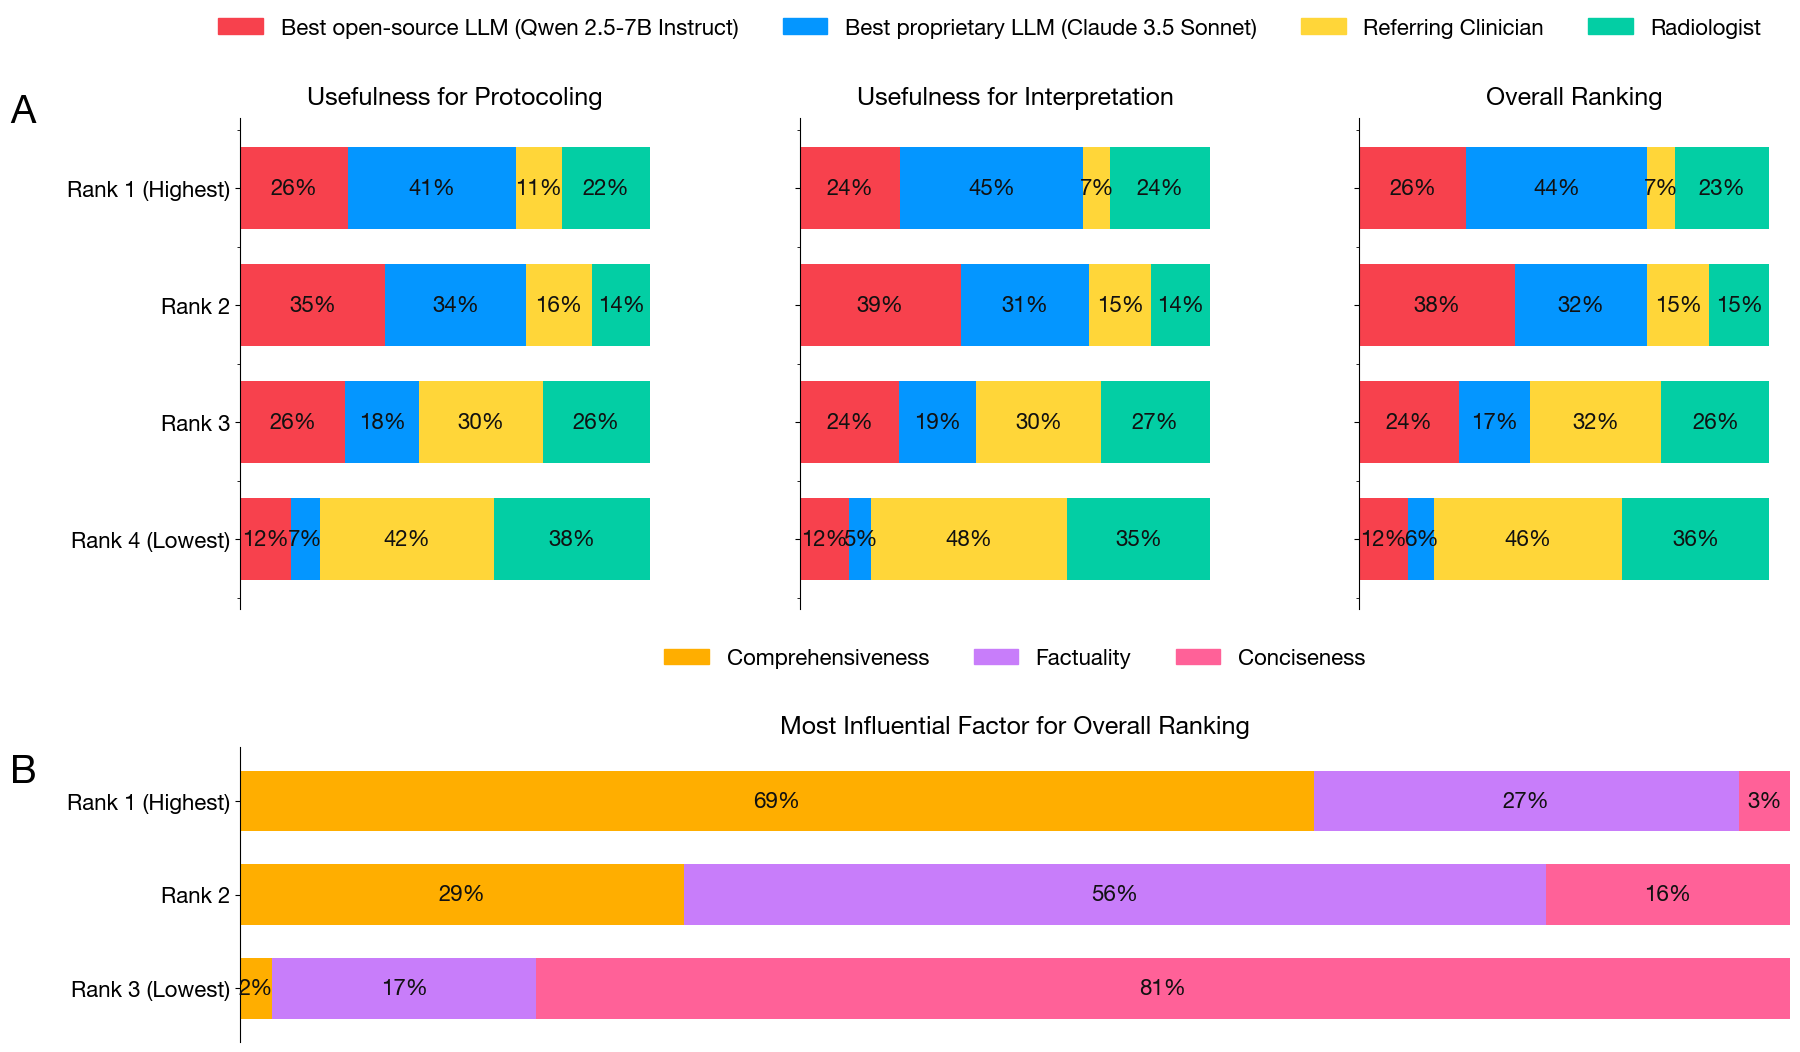

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.font_manager as fm

def rank_labels_from_index(index_like):
    # index_like: e.g., [3,2,1] or Int64Index([3,2,1]) or ['3','2','1']
    r_int = [int(r) for r in list(index_like)]
    hi, lo = min(r_int), max(r_int)  # Rank 1 = Highest, Rank N = Lowest
    labels = []
    for r in r_int:
        if r == hi:
            labels.append(f"Rank {r} (Highest)")
        elif r == lo:
            labels.append(f"Rank {r} (Lowest)")
        else:
            labels.append(f"Rank {r}")
    return labels

# =========================
# Config: order, labels
# =========================
model_order = [
    "llm_indication_qwen",     # Best open-source LLM (Qwen)
    "llm_indication_claude",   # Best proprietary LLM (Claude)
    "original_history",        # Referring Physician
    "additional_history"       # Radiologist
]

DISPLAY_NAMES = {
    "llm_indication_qwen":     "Best open-source LLM (Qwen 2.5-7B Instruct)",
    "llm_indication_claude":   "Best proprietary LLM (Claude 3.5 Sonnet)",
    "original_history":        "Referring Clinician",
    "additional_history":      "Radiologist"
}

# =========================
# Color maps (A vs B distinct)
# =========================
# Subfigure A (model ranking panels)
COLOR_MAP_A = {
    "llm_indication_qwen": "#F7414D", # red
    "llm_indication_claude": "#0496FF", # blue
    "original_history": "#FFD639", # yellow
    "additional_history": "#03CEA4", # green
}


# Subfigure B (factor contribution panel)
COLOR_MAP_B = {
    "Comprehensiveness": "#FFAE00",  # orange
    "Factuality":        "#C87DFA",  # indigo
    "Conciseness":       "#FF6198",  # pink
}


rank_fields = [
    "protocol_usefulness_rank",
    "interpretation_usefulness_rank",
    "overall_rank",
]
subplot_titles = [
    "Usefulness for Protocoling",
    "Usefulness for Interpretation",
    "Overall Ranking"
]

factor_rank_cols = ["factor_ranking_1", "factor_ranking_2", "factor_ranking_3"]
rank_titles = ["Rank 1 (Highest)", "Rank 2", "Rank 3 (Lowest)"]
rank_map = {
    "factor_ranking_1": "Rank 1 (Highest)",
    "factor_ranking_2": "Rank 2",
    "factor_ranking_3": "Rank 3 (Lowest)"
}

# =========================
# Fonts
# =========================
font_path = 'fonts/HelveticaNeue.ttf'
F_TITLE = fm.FontProperties(fname=font_path, size=18)
F_TICK  = fm.FontProperties(fname=font_path, size=16)
F_LABEL = fm.FontProperties(fname=font_path, size=16)
F_LEG   = fm.FontProperties(fname=font_path, size=16)
F_PANEL = fm.FontProperties(fname=font_path, size=28, weight="bold")  # Bigger & bold

# =========================
# Layout
# =========================
fig = plt.figure(figsize=(20, 12))
outer = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[2.0, 1.2], hspace=0.35)

top_gs = outer[0].subgridspec(nrows=1, ncols=3, wspace=0.3)
axes_top = top_gs.subplots(sharey=True)
ax_bottom = fig.add_subplot(outer[1])

# =========================
# TOP: three LLM ranking plots (Subfigure A)
# =========================
for i, (field, title) in enumerate(zip(rank_fields, subplot_titles)):
    ax = axes_top[i]

    # Count & normalize by rank level (rows)
    rank_counts = (
        collated_reader_study_results
        .groupby([field, "source"]).size().unstack(fill_value=0)
    )
    rank_counts = rank_counts.sort_index()[::-1]  # Rank 3 … Rank 1 (top-to-bottom)
    rank_counts = rank_counts.reindex(columns=model_order, fill_value=0)
    rank_percents = rank_counts.div(rank_counts.sum(axis=1), axis=0) * 100

    # Plot
    rank_percents.plot(
        kind="barh", stacked=True, ax=ax,
        color=[COLOR_MAP_A[m] for m in model_order],
        width=0.7, legend=False
    )

    # Style
    ax.set_title(title, fontproperties=F_TITLE, pad=10)
    ax.set_xlabel("")
    ax.set_xticks([])
    ax.set_ylabel("")
    ax.set_yticklabels(rank_labels_from_index(rank_counts.index), fontproperties=F_TICK)
    ax.tick_params(axis='y', labelrotation=0)
    for spine in ("top", "right", "bottom"):
        ax.spines[spine].set_visible(False)

    # Percent labels on segments (>3%)
    for y_idx, row in enumerate(rank_percents.values):
        x_offset = 0.0
        for pct in row:
            if pct > 3:
                ax.text(
                    x_offset + pct / 2.0, y_idx,
                    f"{pct:.0f}%",
                    va="center", ha="center",
                    fontproperties=F_LABEL, color="#111"
                )
            x_offset += pct

# =========================
# BOTTOM: factor plot (Subfigure B)
# =========================
# One vote per case: use unique global_set_id
unique_factors = collated_reader_study_results.drop_duplicates(subset=["global_set_id"])
df_long = unique_factors[factor_rank_cols].melt(var_name="rank_col", value_name="factor")
df_long["rank"] = df_long["rank_col"].map(rank_map)

rank_percents_factors = (
    df_long.groupby(["rank", "factor"]).size().unstack(fill_value=0)
    .reindex(columns=list(COLOR_MAP_B.keys()), fill_value=0)
)
rank_percents_factors = rank_percents_factors.div(rank_percents_factors.sum(axis=1), axis=0) * 100
rank_percents_factors = rank_percents_factors.loc[rank_titles]

rank_percents_factors.plot(
    kind="barh", stacked=True, ax=ax_bottom,
    color=[COLOR_MAP_B[f] for f in rank_percents_factors.columns],
    width=0.65, legend=False
)

ax_bottom.set_xlabel("")
ax_bottom.set_ylabel("")
ax_bottom.set_xlim(0, 100)
ax_bottom.set_xticks([])
ax_bottom.set_yticklabels(rank_titles, fontproperties=F_TICK)
ax_bottom.tick_params(axis='y', labelrotation=0)
for spine in ["top", "right", "bottom"]:
    ax_bottom.spines[spine].set_visible(False)

ax_bottom.invert_yaxis()

# Percent labels
for y_idx, row in enumerate(rank_percents_factors.values):
    x_offset = 0.0
    for pct in row:
        ax_bottom.text(
            x_offset + pct / 2.0, y_idx,
            f"{pct:.0f}%",
            va="center", ha="center",
            fontproperties=F_LABEL, color="#111"
        )
        x_offset += pct

title = "Most Influential Factor for Overall Ranking"
ax_bottom.set_title(title, fontproperties=F_TITLE, pad=10)
        
# =========================
# Legends
# =========================
# Subfigure A legend (models)
legend_handles_models = [mpatches.Patch(color=COLOR_MAP_A[m], label=DISPLAY_NAMES[m]) for m in model_order]
fig.legend(
    handles=legend_handles_models,
    loc='upper center', ncol=4, frameon=False,
    prop=F_LEG, bbox_to_anchor=(0.5, 0.98)
)

# Subfigure B legend (factors)
legend_handles_factors = [mpatches.Patch(color=color, label=label) for label, color in COLOR_MAP_B.items()]
ax_bottom.legend(
    handles=legend_handles_factors,
    loc='lower center', bbox_to_anchor=(0.5, 1.2),
    ncol=3, frameon=False, prop=F_LEG
)

# =========================
# Panel Labels (A, B) — outside beside figure
# =========================
fig.text(0.01, 0.9, "A", fontproperties=F_PANEL, va="top", ha="left")   # beside top row
fig.text(0.01, 0.35, "B", fontproperties=F_PANEL, va="top", ha="left")  # beside bottom row

# =========================
# Save
# =========================
fig.tight_layout(rect=[0.03, 0, 1, 0.97])  # leave space at left for A/B
fig.savefig("figures/fig6_reader_study_rankings_plus_factors.png", dpi=300, bbox_inches="tight")


## Table 3

In [20]:
metrics = ["comprehensiveness", "factuality", "conciseness"]
results = []

source_map = {
    "additional_history": "Radiologist",
    "original_history": "Referring Clinician",
    "llm_indication_claude": "Best-Performing Proprietary LLM",
    "llm_indication_qwen": "Best-Performing Open-source LLM"
}

# Create a mapped column in the source data
collated_reader_study_results["source_display_name"] = (
    collated_reader_study_results["source"].map(source_map)
)

for source, group in collated_reader_study_results.groupby("source_display_name"):
    row = {"source_display_name": source}
    for metric in metrics:
        values = group[metric].dropna()
        q1 = values.quantile(0.25)
        q3 = values.quantile(0.75)
        median = values.median()
        row[metric] = f"{median:.2f} ({q1:.2f}–{q3:.2f})"
    results.append(row)

summary_df = pd.DataFrame(results)
summary_df = summary_df.set_index("source_display_name").T

summary_df = summary_df[
    ["Referring Clinician", 
     "Radiologist", 
     "Best-Performing Open-source LLM", 
     "Best-Performing Proprietary LLM"]
]

summary_df

source_display_name,Referring Clinician,Radiologist,Best-Performing Open-source LLM,Best-Performing Proprietary LLM
comprehensiveness,2.00 (1.00–3.00),3.00 (2.00–4.00),4.00 (3.00–5.00),4.00 (3.00–5.00)
factuality,4.50 (3.00–5.00),5.00 (4.00–5.00),5.00 (4.00–5.00),5.00 (4.00–5.00)
conciseness,5.00 (4.00–5.00),5.00 (4.00–5.00),4.00 (4.00–5.00),5.00 (4.00–5.00)
